***Python Version:*** *3.11.8*  <BR>
# **House Prices - Advanced Regression Techniques**
## **Competition Description:**  
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.    

## **Evaluation**
### **Goal**
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

### **Metric**
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

### **Submission File Format**
The file should contain a header and have the following format:


Id,SalePrice  
1461,169000.1  
1462,187724.1233  
1463,175221  
etc.  

<BR><BR>
# **Rough Plan:**

Although I am aware of stacking and it may provide a better model result if I stack multiple models together, for this project I am mainly going to using the information and models available to learn on Kaggle in the [Kaggle Learn](https://www.kaggle.com/learn) section.  <BR><BR>
The model we are going to use for this project is **XGBoost** or Extreme Gradient Boosting. As Kaggle Learn does not teach all the models available, this seems to be the obvious choice as to what would perform best. We could try out other models and compare, but for this notebook we will focus on correct feature selection, creative feature engineering and hyperparameter tuning.

### **Rough workflow for now:**
1. Domain/Feature understanding + Plan  
2. Initial EDA (nulls, data types)  - 2 to 4 could be as one
3. Handle missing values  
4. Deeper EDA (plots, feature interactions)  
5. Basic encoding  
6. Build base XGBoost model (log SalePrice)  
7. Feature engineering + iterative testing (what feature engineering?, target encoding, PCA values, PCA as feature discovery  
&nbsp;&nbsp; rememeber to also add any encodings/changes to the test set (mapping encodings, etc)
8. Explainability (SHAP, feature importance)  
9. Refine + resubmit  

<details> <!-- remove from .ipynb file, this is for md convert -->
<summary>Markdown (.md) set up code</Summary>

In [12]:
from pandas.io.formats.style_render import StylerRenderer

StylerRenderer.render = lambda self, **kwargs: ""

#stestse

</details>

<Details>
<Summary>Data Set-up code</Summary>

In [7]:
import pandas as pd
df = pd.read_csv(r".\data\train.csv")
print(df.head().to_markdown())

|    |   Id |   MSSubClass | MSZoning   |   LotFrontage |   LotArea | Street   |   Alley | LotShape   | LandContour   | Utilities   | LotConfig   | LandSlope   | Neighborhood   | Condition1   | Condition2   | BldgType   | HouseStyle   |   OverallQual |   OverallCond |   YearBuilt |   YearRemodAdd | RoofStyle   | RoofMatl   | Exterior1st   | Exterior2nd   | MasVnrType   |   MasVnrArea | ExterQual   | ExterCond   | Foundation   | BsmtQual   | BsmtCond   | BsmtExposure   | BsmtFinType1   |   BsmtFinSF1 | BsmtFinType2   |   BsmtFinSF2 |   BsmtUnfSF |   TotalBsmtSF | Heating   | HeatingQC   | CentralAir   | Electrical   |   1stFlrSF |   2ndFlrSF |   LowQualFinSF |   GrLivArea |   BsmtFullBath |   BsmtHalfBath |   FullBath |   HalfBath |   BedroomAbvGr |   KitchenAbvGr | KitchenQual   |   TotRmsAbvGrd | Functional   |   Fireplaces | FireplaceQu   | GarageType   |   GarageYrBlt | GarageFinish   |   GarageCars |   GarageArea | GarageQual   | GarageCond   | PavedDrive   |   WoodDeckSF |   OpenP

</details>

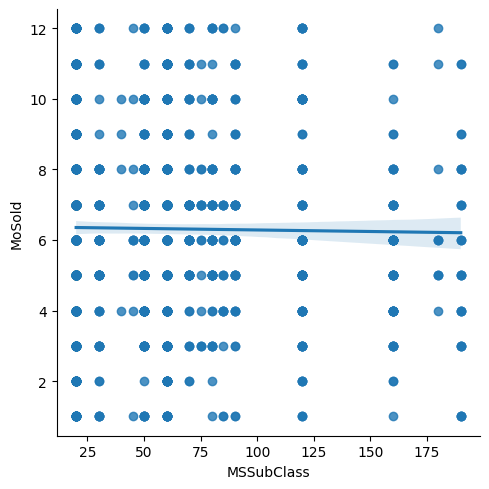

In [9]:
import seaborn as sns

sns.lmplot(data = df, x='MSSubClass', y='MoSold');

In [11]:
df.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                     mean    median count
MSSubClass                               
20          185224.811567  159250.0   536
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          239948.501672  215200.0   299
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52
120         200779.080460  192000.0    87
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30

<BR><BR>
# **1. Domain Knowledge, Feature review and transformation plan**

First we will start by looking through the [data_description.txt](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=data_description.txt) file from the competition page feature by feature.<BR>
  
Some of the things that initially come to mind to explore are:
1. **Feature description** — What does it represent?
2. **Possible values** — Especially for categoricals; what do the values mean?
3. **Data type and missing values** — Type, % missing, any obvious issues
4. **Encoding** — Does it have a natural or ordinal order?
5. **Grouping** — Can it be grouped with similar features (e.g. size, time, location)?
6. **Interactions** — Does this feature affect or depend on other features?
7. **Expected importance** — High/medium/low signal? Any gut feel?
8. **Missing value strategy** — If there are few nulls, what could we fill with?
9. **Area knowledge** — Any local context (e.g. Ames zoning, neighborhoods)?
10. **Transformation ideas** — Binning, ratios, log scale, engineered combos?

SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.<BR>

## **Feature List**
[**MSSubClass:**](#mssubclass) The building class<BR>
[**MSZoning:**]() The general zoning classification<BR>
[**LotFrontage:**](#lotfrontage) Linear feet of street connected to property<BR>
[**LotArea:**](#lotarea) Lot size in square feet<BR>
[**Street:**](#street) Type of road access<BR>
[**Alley:**](#alley) Type of alley access<BR>
[**LotShape:**](#lotshape) General shape of property<BR>
[**LandContour:**](#landcontour) Flatness of the property<BR>
[**Utilities:**](#utilities) Type of utilities available<BR>
[**LotConfig:**]() Lot configuration<BR>
[**LandSlope:**]() Slope of property<BR>
[**Neighborhood:**]() Physical locations within Ames city limits<BR>
[**Condition1:**]() Proximity to main road or railroad<BR>
[**Condition2:**]() Proximity to main road or railroad (if a second is present)<BR>
[**BldgType:**]() Type of dwelling<BR>
[**HouseStyle:**]() Style of dwelling<BR>
[**OverallQual:**]() Overall material and finish quality<BR>
[**OverallCond:**]() Overall condition rating<BR>
[**YearBuilt:**]() Original construction date<BR>
[**YearRemodAdd:**]() Remodel date<BR>
[**RoofStyle:**]() Type of roof<BR>
[**RoofMatl:**]() Roof material<BR>
[**Exterior1st:**]() Exterior covering on house<BR>
[**Exterior2nd:**]() Exterior covering on house (if more than one material)<BR>
[**MasVnrType:**]() Masonry veneer type<BR>
[**MasVnrArea:**]() Masonry veneer area in square feet<BR>
[**ExterQual:**]() Exterior material quality<BR>
[**ExterCond:**]() Present condition of the material on the exterior<BR>
[**Foundation:**]() Type of foundation<BR>
[**BsmtQual:**]() Height of the basement<BR>
[**BsmtCond:**]() General condition of the basement<BR>
[**BsmtExposure:**]() Walkout or garden level basement walls<BR>
[**BsmtFinType1:**]() Quality of basement finished area<BR>
[**BsmtFinSF1:**]() Type 1 finished square feet<BR>
[**BsmtFinType2:**]() Quality of second finished area (if present)<BR>
[**BsmtFinSF2:**]() Type 2 finished square feet<BR>
[**BsmtUnfSF:**]() Unfinished square feet of basement area<BR>
[**TotalBsmtSF:**]() Total square feet of basement area<BR>
[**Heating:**]() Type of heating<BR>
[**HeatingQC:**]() Heating quality and condition<BR>
[**CentralAir:**]() Central air conditioning<BR>
[**Electrical:**]() Electrical system<BR>
[**1stFlrSF:**]() First Floor square feet<BR>
[**2ndFlrSF:**]() Second floor square feet<BR>
[**LowQualFinSF:**]() Low quality finished square feet (all floors)<BR>
[**GrLivArea:**]() Above grade (ground) living area square feet<BR>
[**BsmtFullBath:**]() Basement full bathrooms<BR>
[**BsmtHalfBath:**]() Basement half bathrooms<BR>
[**FullBath:**]() Full bathrooms above grade<BR>
[**HalfBath:**]() Half baths above grade<BR>
[**Bedroom:**]() Number of bedrooms above basement level<BR>
[**Kitchen:**]() Number of kitchens<BR>
[**KitchenQual:**]() Kitchen quality<BR>
[**TotRmsAbvGrd:**]() Total rooms above grade (does not include bathrooms)<BR>
[**Functional:**]() Home functionality rating<BR>
[**Fireplaces:**]() Number of fireplaces<BR>
[**FireplaceQu:**]() Fireplace quality<BR>
[**GarageType:**]() Garage location<BR>
[**GarageYrBlt:**]() Year garage was built<BR>
[**GarageFinish:**]() Interior finish of the garage<BR>
[**GarageCars:**]() Size of garage in car capacity<BR>
[**GarageArea:**]() Size of garage in square feet<BR>
[**GarageQual:**]() Garage quality<BR>
[**GarageCond:**]() Garage condition<BR>
[**PavedDrive:**]() Paved driveway<BR>
[**WoodDeckSF:**]() Wood deck area in square feet<BR>
[**OpenPorchSF:**]() Open porch area in square feet<BR>
[**EnclosedPorch:**]() Enclosed porch area in square feet<BR>
[**3SsnPorch:**]() Three season porch area in square feet<BR>
[**ScreenPorch:**]() Screen porch area in square feet<BR>
[**PoolArea:**]() Pool area in square feet<BR>
[**PoolQC:**]() Pool quality<BR>
[**Fence:**]() Fence quality<BR>
[**MiscFeature:**]() Miscellaneous feature not covered in other categories<BR>
[**MiscVal:**]() $Value of miscellaneous feature<BR>
[**MoSold:**]() Month Sold<BR>
[**YrSold:**]() Year Sold<BR>
[**SaleType:**]() Type of sale<BR>
[**SaleCondition:**]() Condition of sale<BR>

## **MSSubClass**
***description:***

Identifies the type of dwelling involved in the sale.

***Categories:***

        Value  Description
        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES


[*back to feature list*](#feature-list)

In [16]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000



MSZoning: Identifies the general zoning classification of the sale.
		
***Categories***:

       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
	


## **LotFrontage:**
***Description:*** Linear feet of street connected to property

[*back to feature list*](#feature-list)

## **LotArea:**
***Description:*** Lot size in square feet

[*back to feature list*](#feature-list)

## **Street:**
***Description:*** Type of road access to property

       Grvl	Gravel	
       Pave	Paved

[*back to feature list*](#feature-list)
       	
## **Alley:**
***Description:*** Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
		
[*back to feature list*](#feature-list)

## **LotShape:** 
***Description:*** General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

[*back to feature list*](#feature-list)
       
## **LandContour:** 
***Description:*** Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression

[*back to feature list*](#feature-list)
		
## **Utilities:** 
***Description:*** Type of utilities available
		 
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
[*back to feature list*](#feature-list)
	
## **LotConfig:** 
***Description:*** Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property
[*back to feature list*](#feature-list)
	
## **LandSlope:** 
***Description:*** Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope
[*back to feature list*](#feature-list)
	
## **Neighborhood:** 
***Description:*** Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker
[*back to feature list*](#feature-list)
			
## **Condition1:** 
***Description:*** Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
[*back to feature list*](#feature-list)
	
## **Condition2:** 
***Description:*** Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
[*back to feature list*](#feature-list)
	
## **BldgType:** 
***Description:*** Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
[*back to feature list*](#feature-list)
	
## **HouseStyle:** 
***Description:*** Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level
[*back to feature list*](#feature-list)
	
## **OverallQual:** 
***Description:*** Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
[*back to feature list*](#feature-list)
	
## **OverallCond:** 
***Description:*** Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor
[*back to feature list*](#feature-list)
		
## **YearBuilt:** 
***Description:*** Original construction date
[*back to feature list*](#feature-list)

## **YearRemodAdd:** 
***Description:*** Remodel date (same as construction date if no remodeling or additions)
[*back to feature list*](#feature-list)

## **RoofStyle:** 
***Description:*** Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed
[*back to feature list*](#feature-list)
		
## **RoofMatl:** 
***Description:*** Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles
[*back to feature list*](#feature-list)
		
## **Exterior1st:** 
***Description:*** Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
[*back to feature list*](#feature-list)
	
## **Exterior2nd:** 
***Description:*** Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
[*back to feature list*](#feature-list)
	
## **MasVnrType:** 
***Description:*** Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
[*back to feature list*](#feature-list)
	
## **MasVnrArea:** 
***Description:*** Masonry veneer area in square feet
[*back to feature list*](#feature-list)

## **ExterQual:** 
***Description:*** Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
[*back to feature list*](#feature-list)
		
## **ExterCond:** 
***Description:*** Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
[*back to feature list*](#feature-list)
		
## **Foundation:** 
***Description:*** Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
[*back to feature list*](#feature-list)
		
## **BsmtQual:** 
***Description:*** Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
[*back to feature list*](#feature-list)
		
## **BsmtCond:** 
***Description:*** Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
[*back to feature list*](#feature-list)
	
## **BsmtExposure:** 
***Description:*** Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
[*back to feature list*](#feature-list)
	
## **BsmtFinType1:** 
***Description:*** Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
[*back to feature list*](#feature-list)
		
## **BsmtFinSF1:** 
***Description:*** Type 1 finished square feet
[*back to feature list*](#feature-list)

## **BsmtFinType2:** 
***Description:*** Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
[*back to feature list*](#feature-list)

## **BsmtFinSF2:** 
***Description:*** Type 2 finished square feet
[*back to feature list*](#feature-list)

## **BsmtUnfSF:** 
***Description:*** Unfinished square feet of basement area
[*back to feature list*](#feature-list)

## **TotalBsmtSF:** 
***Description:*** Total square feet of basement area
[*back to feature list*](#feature-list)

## **Heating:** 
***Description:*** Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace
[*back to feature list*](#feature-list)
		
## **HeatingQC:** 
***Description:*** Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
[*back to feature list*](#feature-list)
		
## **CentralAir:** 
***Description:*** Central air conditioning

       N	No
       Y	Yes
[*back to feature list*](#feature-list)
		
## **Electrical:** 
***Description:*** Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
[*back to feature list*](#feature-list)
		
## **1stFlrSF:** 
***Description:*** First Floor square feet
[*back to feature list*](#feature-list)
 
## **2ndFlrSF:** 
***Description:*** Second floor square feet
[*back to feature list*](#feature-list)

## **LowQualFinSF:** 
***Description:*** Low quality finished square feet (all floors)
[*back to feature list*](#feature-list)

## **GrLivArea:** 
***Description:*** Above grade (ground) living area square feet
[*back to feature list*](#feature-list)

## **BsmtFullBath:** 
***Description:*** Basement full bathrooms
[*back to feature list*](#feature-list)

## **BsmtHalfBath:** 
***Description:*** Basement half bathrooms
[*back to feature list*](#feature-list)

## **FullBath:** 
***Description:*** Full bathrooms above grade
[*back to feature list*](#feature-list)

## **HalfBath:** 
***Description:*** Half baths above grade
[*back to feature list*](#feature-list)

## **Bedroom:** 
***Description:*** Bedrooms above grade (does NOT include basement bedrooms)
[*back to feature list*](#feature-list)

## **Kitchen:** 
***Description:*** Kitchens above grade
[*back to feature list*](#feature-list)

## **KitchenQual:** 
***Description:*** Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
[*back to feature list*](#feature-list)
       	
## **TotRmsAbvGrd:** 
***Description:*** Total rooms above grade (does not include bathrooms)
[*back to feature list*](#feature-list)

## **Functional:** 
***Description:*** Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
[*back to feature list*](#feature-list)
		
## **Fireplaces:** 
***Description:*** Number of fireplaces
[*back to feature list*](#feature-list)

## **FireplaceQu:** 
***Description:*** Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
[*back to feature list*](#feature-list)
		
## **GarageType:** 
***Description:*** Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
[*back to feature list*](#feature-list)
		
## **GarageYrBlt:** 
***Description:*** Year garage was built
[*back to feature list*](#feature-list)
		
## **GarageFinish:** 
***Description:*** Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
[*back to feature list*](#feature-list)
		
## **GarageCars:** 
***Description:*** Size of garage in car capacity
[*back to feature list*](#feature-list)

## **GarageArea:** 
***Description:*** Size of garage in square feet
[*back to feature list*](#feature-list)

## **GarageQual:** 
***Description:*** Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
[*back to feature list*](#feature-list)
		
## **GarageCond:** 
***Description:*** Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
[*back to feature list*](#feature-list)
		
## **PavedDrive:** 
***Description:*** Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
[*back to feature list*](#feature-list)
		
## **WoodDeckSF:** 
***Description:*** Wood deck area in square feet
[*back to feature list*](#feature-list)

## **OpenPorchSF:** 
***Description:*** Open porch area in square feet
[*back to feature list*](#feature-list)

## **EnclosedPorch:** 
***Description:*** Enclosed porch area in square feet
[*back to feature list*](#feature-list)

## **3SsnPorch:** 
***Description:*** Three season porch area in square feet
[*back to feature list*](#feature-list)

## **ScreenPorch:** 
***Description:*** Screen porch area in square feet
[*back to feature list*](#feature-list)

## **PoolArea:** 
***Description:*** Pool area in square feet
[*back to feature list*](#feature-list)

## **PoolQC:** 
***Description:*** Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
[*back to feature list*](#feature-list)
		
## **Fence:** 
***Description:*** Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

[*back to feature list*](#feature-list)
	
## **MiscFeature:** 
***Description:*** Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None
[*back to feature list*](#feature-list)
		
## **MiscVal:** 
***Description:*** $Value of miscellaneous feature
[*back to feature list*](#feature-list)

## **MoSold:** 
***Description:*** Month Sold (MM)
[*back to feature list*](#feature-list)

## **YrSold:** 
***Description:*** Year Sold (YYYY)
[*back to feature list*](#feature-list)

## **SaleType:** 
***Description:*** Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
[*back to feature list*](#feature-list)
		
## **SaleCondition:** 
***Description:*** Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)



#
